In [173]:
using Plots
using LinearAlgebra
using SparseArrays
using Random

In [174]:
L  = 20π       # Domain size
DT = 0.005     # Time step
NT = 10000     # Number of time steps
NG = 320       # Number of grid cells
N  = NG * 20   # Number of particles
WP = 1.        # Plasma frequency
QM = -1.       # Charge/mass ratio
V0 = 0.9       # Stream velocity
VT = 0.0000001 # Thermal speed

# perturbation 
XP1 = 1.0 
mode = 1

Q = WP^2 / (QM*N/L)  # rho0*L/N: charge carried by a single particle?
rho_back = -Q*N/L  # Background charge density?
dx = L / NG # Grid step

# Auxilliary vectors
p = [1:N; 1:N]  # Some indices up to N
Poisson = spdiagm(-1 => ones(Float64,NG-2),
                   0 => -2*ones(Float64,NG),
                   1 => ones(Float64,NG-2))

320×320 SparseMatrixCSC{Float64,Int64} with 956 stored entries:
  [1  ,   1]  =  -2.0
  [2  ,   1]  =  1.0
  [1  ,   2]  =  1.0
  [2  ,   2]  =  -2.0
  [3  ,   2]  =  1.0
  [2  ,   3]  =  1.0
  [3  ,   3]  =  -2.0
  [4  ,   3]  =  1.0
  [3  ,   4]  =  1.0
  [4  ,   4]  =  -2.0
  [5  ,   4]  =  1.0
  [4  ,   5]  =  1.0
  ⋮
  [315, 316]  =  1.0
  [316, 316]  =  -2.0
  [317, 316]  =  1.0
  [316, 317]  =  1.0
  [317, 317]  =  -2.0
  [318, 317]  =  1.0
  [317, 318]  =  1.0
  [318, 318]  =  -2.0
  [319, 318]  =  1.0
  [318, 319]  =  1.0
  [319, 319]  =  -2.0
  [320, 320]  =  -2.0

In [175]:
# Cell center coordinates
xg = collect(range(0, stop=L-dx, length=NG)) .+ dx/2
xp = collect(range(0, stop=L-L/N, length=N))  # Particle positions

rng = MersenneTwister(1234)

vp = VT .* (1 .- VT.^2).^(-0.5) .* randn(rng, Float64, N) # Particle momentum, initially Maxwellian
pm = collect(0:N-1)
pm = 1 .- 2 * mod.(pm.+1, 2)
vp .+= pm * (V0 * (1 - V0^2)^(-0.5)) # Momentum + stream velocity

# Add electron perturbation to excite the desired mode
xp .+= XP1 * (L/N) * sin.(2 * π * xp / L * mode)
xp[map(x -> x <  0, xp)] .+= L
xp[map(x -> x >= L, xp)] .-= L

0-element view(::Array{Float64,1}, Any[]) with eltype Float64

In [176]:
Poisson = spdiagm(-1 => ones(Float64,NG-2),
                   0 => -2*ones(Float64,NG),
                   1 => ones(Float64,NG-2))

320×320 SparseMatrixCSC{Float64,Int64} with 956 stored entries:
  [1  ,   1]  =  -2.0
  [2  ,   1]  =  1.0
  [1  ,   2]  =  1.0
  [2  ,   2]  =  -2.0
  [3  ,   2]  =  1.0
  [2  ,   3]  =  1.0
  [3  ,   3]  =  -2.0
  [4  ,   3]  =  1.0
  [3  ,   4]  =  1.0
  [4  ,   4]  =  -2.0
  [5  ,   4]  =  1.0
  [4  ,   5]  =  1.0
  ⋮
  [315, 316]  =  1.0
  [316, 316]  =  -2.0
  [317, 316]  =  1.0
  [316, 317]  =  1.0
  [317, 317]  =  -2.0
  [318, 317]  =  1.0
  [317, 318]  =  1.0
  [318, 318]  =  -2.0
  [319, 318]  =  1.0
  [318, 319]  =  1.0
  [319, 319]  =  -2.0
  [320, 320]  =  -2.0

In [180]:
function compute_rho(xp)
    # Project particles -> grid
    g1 = floor.(Int64,floor.(xp/dx .- 0.5))
    g = floor.(Int64,vcat(g1, g1.+1))
    fraz1 = 1 .- abs.(xp/dx .- g1 .- 0.5)
    fraz = vcat(fraz1, 1 .- fraz1)
    g[map( x -> x < 0   , g)] .+= NG
    g[map( x -> x > NG-1, g)] .-= NG
    g .+= 1
    println(minimum(p)," - ", maximum(p))
    println(minimum(g)," - ", maximum(g))
    mat = sparse(p, g, fraz, N, NG)
    Q / dx * vec(sum(mat,dims=1)) .+ rho_back
end

compute_rho (generic function with 1 method)

In [181]:
function solve_poisson( rho )
    # Compute electric field potential
    Φ = zeros(Float64,NG)
    rho .*= (-dx^2)
    sol = Poisson \  rho
    Φ[1:end-1] .= sol[1:end-1]
    Φ[end] = 0.0
    # Electric field on the grid
    (circshift(Φ, 1) - circshift(Φ, -1)) ./ (2dx)
end  

solve_poisson (generic function with 1 method)

1 - 6400
1 - 320
typeof(rho) = Array{Float64,1}


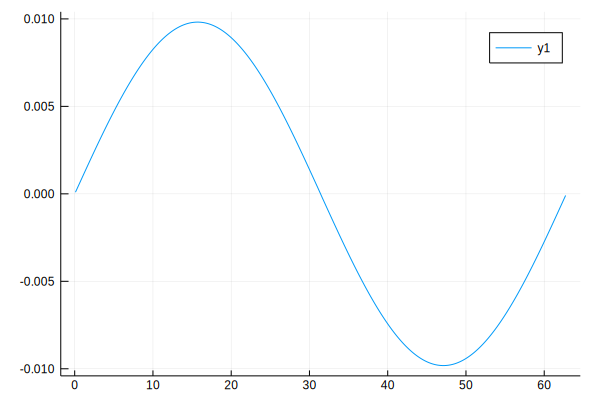

In [182]:
rho = compute_rho(xp)  
@show typeof(rho)
Eg = solve_poisson(rho)
plot(xg, Eg)

![](Eg.png)